In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
#from surprise import Reader, Dataset, SVD, evaluate

import warnings; warnings.simplefilter('ignore')

In [4]:
input_cleaned_file_path = '/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/data/processed/imdb'
output_files = '/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/data/processed/outputs'

In [5]:
def read_file(file_name):
    return pd.read_csv(open(f"{input_cleaned_file_path}/{file_name}", 'r'))

In [6]:
def write_file(df,file_name):
    return df.to_csv(f"{output_files}/{file_name}", index=False)

In [7]:
df_movie = read_file('cleaned_title_basics.csv')

In [8]:
df_movie.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [9]:
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10232298 entries, 0 to 10232297
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         int64 
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: int64(1), object(8)
memory usage: 702.6+ MB


In [10]:
df_movie_ratings=read_file('cleaned_title_ratings.csv')

In [11]:
df_movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359483 entries, 0 to 1359482
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1359483 non-null  object 
 1   averageRating  1359483 non-null  float64
 2   numVotes       1359483 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 31.1+ MB


In [12]:
df_movie_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2000
1,tt0000002,5.8,269
2,tt0000003,6.5,1890
3,tt0000004,5.5,178
4,tt0000005,6.2,2676


# Top Movies Chart

IMDB's weighted rating formula as below -
 
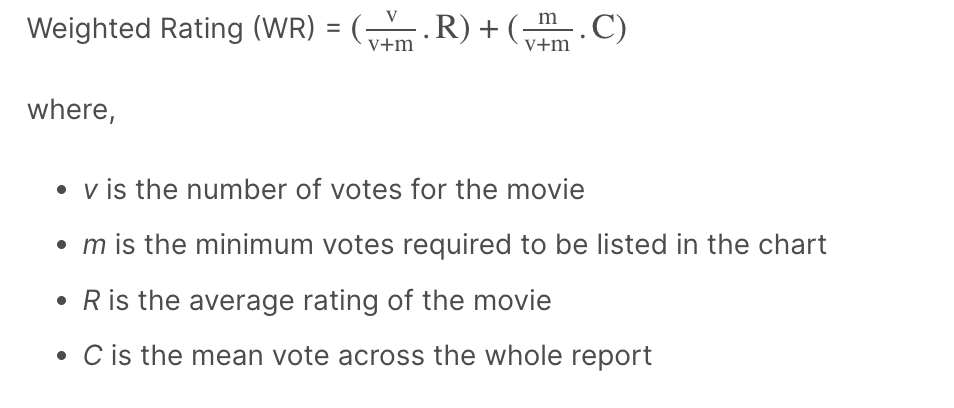

The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

In [13]:
# Mean Votes across the whole report
C = df_movie_ratings['averageRating'].mean()
C

6.958241405004698

In [14]:
# Minimum votes required to be listed in the chart
m = df_movie_ratings['numVotes'].quantile(0.95)
m

1337.0

In [15]:
df_qualified_movies = df_movie_ratings[(df_movie_ratings['numVotes'] >= m)]

In [16]:
df_qualified_movies.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2000
2,tt0000003,6.5,1890
4,tt0000005,6.2,2676
7,tt0000008,5.4,2144
9,tt0000010,6.9,7318


In [17]:
df_qualified_movies.shape

(67991, 3)

In [18]:
# Calculate weighted rating
def weighted_rating(x):
    v = x['numVotes']
    R = x['averageRating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [19]:
# Calculate weighted rating for qualified movies
df_qualified_movies['weighted_rating'] = df_qualified_movies.apply(weighted_rating, axis=1)

In [20]:
df_qualified_movies.head()

,tconst,averageRating,numVotes,weighted_rating
0,tt0000001,5.7,2000,6.204126
2,tt0000003,6.5,1890,6.689857
4,tt0000005,6.2,2676,6.452621
7,tt0000008,5.4,2144,5.998497
9,tt0000010,6.9,7318,6.908997


In [21]:
df_qualified_movies.shape

(67991, 4)

In [22]:
df_qualified_movies = df_qualified_movies.sort_values('weighted_rating', ascending=False)

In [23]:
df_qualified_movies

,tconst,averageRating,numVotes,weighted_rating
905942,tt2301451,10.0,206716,9.980453
1081275,tt4283088,9.9,219980,9.882229
1081277,tt4283094,9.9,156575,9.875093
905944,tt2301455,9.9,134152,9.870971
879356,tt2178784,9.9,114188,9.865954
...,...,...,...,...
1187874,tt6038600,1.2,40081,1.385880
1281174,tt7886848,1.2,96477,1.278708
1250592,tt7221896,1.0,39243,1.196308
968041,tt27528139,1.1,82015,1.193969


In [24]:
df_movie[df_movie['tconst'] == 'tt2301451']

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
5859300,tt2301451,tvEpisode,Ozymandias,Ozymandias,0,2013,\N,47,"Crime,Drama,Thriller"


## Combine movies and movie ratings

In [25]:
# Join the top trending movies wiht the movie basics to get other details.
df_qualified_movies = df_qualified_movies.set_index('tconst').join(df_movie.set_index('tconst'),lsuffix='_qualified', rsuffix='_movie')

In [26]:
df_qualified_movies['tconst'] = df_qualified_movies.index

In [27]:
df_qualified_movies.shape

(67991, 12)

In [28]:
df_qualified_movies.head(10)

,averageRating,numVotes,weighted_rating,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,tconst
tconst,,,,,,,,,,,,
tt2301451,10.0,206716,9.980453,tvEpisode,Ozymandias,Ozymandias,0,2013,\N,47,"Crime,Drama,Thriller",tt2301451
tt4283088,9.9,219980,9.882229,tvEpisode,Battle of the Bastards,Battle of the Bastards,0,2016,\N,60,"Action,Adventure,Drama",tt4283088
tt4283094,9.9,156575,9.875093,tvEpisode,The Winds of Winter,The Winds of Winter,0,2016,\N,68,"Action,Adventure,Drama",tt4283094
tt2301455,9.9,134152,9.870971,tvEpisode,Felina,Felina,0,2013,\N,55,"Crime,Drama,Thriller",tt2301455
tt2178784,9.9,114188,9.865954,tvEpisode,The Rains of Castamere,The Rains of Castamere,0,2013,\N,51,"Action,Adventure,Drama",tt2178784
tt1683088,9.9,71313,9.845862,tvEpisode,Face Off,Face Off,0,2011,\N,50,"Crime,Drama,Thriller",tt1683088
tt12187040,9.9,53757,9.828611,tvEpisode,Plan and Execution,Plan and Execution,0,2022,\N,50,"Crime,Drama",tt12187040
tt21151974,9.9,33321,9.786516,tvEpisode,Connor's Wedding,Connor's Wedding,0,2023,\N,62,"Comedy,Drama",tt21151974
tt8084176,9.9,32899,9.785117,tvEpisode,407 Proxy Authentication Required,407 Proxy Authentication Required,0,2019,\N,56,"Crime,Drama,Thriller",tt8084176


In [29]:
df_qualified_movies['titleType'].value_counts()

titleType
movie           35085
tvEpisode       19289
tvSeries         6900
tvMovie          1883
tvMiniSeries     1481
video            1111
short            1055
videoGame         794
tvSpecial         340
tvShort            53
Name: count, dtype: int64

## Save Top trending content

In [30]:
## Save Top trending content
write_file(df_qualified_movies,'top_trending_content.csv')

In [31]:
df_qualified_movies_movie = df_qualified_movies[df_qualified_movies['titleType']=='movie']

In [32]:
# Top 20 movies
df_qualified_movies_movie.head(20)

,averageRating,numVotes,weighted_rating,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,tconst
tconst,,,,,,,,,,,,
tt28145495,9.8,8230,9.402861,movie,Uruttu Tech,Uruttu Tech,0,2023,\N,66,Comedy,tt28145495
tt0111161,9.3,2807661,9.298885,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161
tt16747572,9.5,10455,9.211810,movie,The Silence of Swastika,The Silence of Swastika,0,2021,\N,56,"Documentary,History",tt16747572
tt0068646,9.2,1956575,9.198469,movie,The Godfather,The Godfather,0,1972,\N,175,"Crime,Drama",tt0068646
tt0252487,9.2,42252,9.131239,movie,The Chaos Class,Hababam Sinifi,0,1975,\N,87,"Comedy,Drama",tt0252487
tt2592910,9.1,46894,9.040629,movie,CM101MMXI Fundamentals,CM101MMXI Fundamentals,0,2013,\N,139,"Comedy,Documentary",tt2592910
tt0468569,9.0,2789410,8.999022,movie,The Dark Knight,The Dark Knight,0,2008,\N,152,"Action,Crime,Drama",tt0468569
tt0167260,9.0,1921917,8.998581,movie,The Lord of the Rings: The Return of the King,The Lord of the Rings: The Return of the King,0,2003,\N,201,"Action,Adventure,Drama",tt0167260
tt0108052,9.0,1411437,8.998068,movie,Schindler's List,Schindler's List,0,1993,\N,195,"Biography,Drama,History",tt0108052


In [33]:
# Top 20 TV series
df_qualified_movies_tvseries = df_qualified_movies[df_qualified_movies['titleType']=='tvSeries']

In [34]:
# Top 20 TV series that are thriller
df_qualified_movies_tvseries[df_qualified_movies_tvseries['genres'].str.contains('Thriller')].head(20)

,averageRating,numVotes,weighted_rating,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,tconst
tconst,,,,,,,,,,,,
tt0903747,9.5,2048283,9.498342,tvSeries,Breaking Bad,Breaking Bad,0,2008,2013,49,"Crime,Drama,Thriller",tt0903747
tt0306414,9.3,363013,9.291407,tvSeries,The Wire,The Wire,0,2002,2008,59,"Crime,Drama,Thriller",tt0306414
tt2802850,8.9,390401,8.893373,tvSeries,Fargo,Fargo,0,2014,2024,53,"Crime,Drama,Thriller",tt2802850
tt7450814,9.0,17751,8.856987,tvSeries,Koombiyo,Koombiyo,0,2017,2018,20,"Crime,Drama,Thriller",tt7450814
tt6108262,8.9,12008,8.705460,tvSeries,Black Sun,Senke nad Balkanom,0,2017,\N,60,"Crime,Drama,Thriller",tt6108262
tt0118421,8.7,104185,8.677931,tvSeries,Oz,Oz,0,1997,2003,55,"Crime,Drama,Thriller",tt0118421
tt0286486,8.7,85425,8.673160,tvSeries,The Shield,The Shield,0,2002,2008,47,"Crime,Drama,Thriller",tt0286486
tt1534360,8.7,35550,8.636869,tvSeries,Ezel,Ezel,0,2009,2011,90,"Crime,Drama,Thriller",tt1534360
tt12714854,8.7,29761,8.625116,tvSeries,Mumbai Diaries,Mumbai Diaries,0,2021,\N,\N,"Drama,Thriller",tt12714854


In [35]:
# Function for selecting top trending content by title type
def top_trending_title_type(df,title_type):
    return df[df['titleType'] == title_type]

In [36]:
# Function for selecting top trending content by genres
def top_trending_genres(df,genres):
    return df[df['genres'].str.contains(genres)]

In [37]:
top_trending_genres(top_trending_title_type(df_qualified_movies,'movie'),'Thriller').head(20)

,averageRating,numVotes,weighted_rating,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,tconst
tconst,,,,,,,,,,,,
tt5354160,9.0,29124,8.910383,movie,Mirror Game,Aynabaji,0,2016,\N,147,"Crime,Mystery,Thriller",tt5354160
tt6019206,8.8,15105,8.650235,movie,Kill Bill: The Whole Bloody Affair,Kill Bill: The Whole Bloody Affair,0,2006,\N,247,"Action,Crime,Thriller",tt6019206
tt0102926,8.6,1499158,8.598537,movie,The Silence of the Lambs,The Silence of the Lambs,0,1991,\N,118,"Crime,Drama,Thriller",tt0102926
tt23647024,9.5,2134,8.520936,movie,Ap04ramapuram,Ap04ramapuram,0,2022,\N,144,"Drama,Thriller",tt23647024
tt0407887,8.5,1383942,8.498512,movie,The Departed,The Departed,0,2006,\N,151,"Crime,Drama,Thriller",tt0407887
tt6751668,8.5,893615,8.497697,movie,Parasite,Gisaengchung,0,2019,\N,132,"Drama,Thriller",tt6751668
tt0054215,8.5,700909,8.497065,movie,Psycho,Psycho,0,1960,\N,109,"Horror,Mystery,Thriller",tt0054215
tt0047396,8.5,510284,8.495971,movie,Rear Window,Rear Window,0,1954,\N,112,"Mystery,Thriller",tt0047396
tt0058625,8.5,21757,8.410742,movie,Woman in the Dunes,Suna no onna,0,1964,\N,147,"Drama,Thriller",tt0058625
